In [1]:
%run "0_Helper_Function_GLM_VOL_OMR.ipynb"

...
----------------------------------------------------------------------
Ran 3 tests in 11.078s

OK


# Convert StimLog to Panda Dataframe

In [2]:
filename_mat='G:\MovieIllustration\stimlog_2019_10_03_19_16_08.mat'
filename_pkl=Path(filename_mat.replace('.mat','.pickle'))

In [3]:
mat_contents = sio.loadmat(filename_mat, struct_as_record=False, squeeze_me=True)
mdata = mat_contents['StimLog'] # variable in mat file
LogLength=mdata.Length
NumField=(len(mdata.Values))

In [4]:
df=[]
for i in range(NumField):
    # The index is define from the end since all the uniforms don't start simultaneously
    NumId=len(mdata.Values[i].values)
    tmp=pd.DataFrame(mdata.Values[i].values,columns=[mdata.Values[i].name],index=range(LogLength-NumId,LogLength))
    if i==0:
        df=tmp
    else:
        df=pd.concat([df,tmp], axis=1)
stim_log=df
stim_log.rename(columns={'iGlobalTime':'i_global_time','iTimeDelta':'i_time_delta','StopWatchTime':'spot_watch_time','Id':'cam_frame',
                             'TimeCam':'time_cam_shader',
                             'xPos':'x_pos_shader','yPos':'y_pos_shader','FOrient':'fish_orientation_shader',
                             'Orientation':'grating_orientation','Speed_mm':'grating_speed',
                             }, inplace=True)
############################ ADD GRATING PHASE ###############################
Frequency_mm=1./10.; # unit is mm^-1
rig_size=66.
frequency=Frequency_mm*rig_size/1.8

speed=stim_log.grating_speed.values*1.8/rig_size
time=stim_log.i_global_time.values
phase=-speed*(time);
phase=np.mod(2.*np.pi* phase  * frequency+np.pi,2*np.pi)
value = 0.5 + 0.5 * np.sin(phase);
value[value>0.5]=1
value[value<0.5]=0

stim_log.insert(2, "grating_phase",phase, True) 
stim_log.insert(3, "grating_value",value, True) 

############################ SAVE ###############################

stim_log.to_pickle(filename_pkl, compression='infer')

In [5]:
stim_log.head(3)

grating_orientation  grating_speed  grating_phase  grating_value  \
0                 90.0           10.0       3.141593            0.0   
1                 90.0           10.0       3.033840            1.0   
2                 90.0           10.0       2.929118            1.0   

   i_global_time  spot_watch_time  i_time_delta  x_pos_shader  y_pos_shader  \
0       0.000000         0.039242      0.017149           NaN           NaN   
1       0.017149         0.103728      0.016667           NaN           NaN   
2       0.033816         0.104324      0.051025           NaN           NaN   

   fish_orientation_shader  time_cam_shader  cam_frame  
0                      NaN              NaN        NaN  
1                      NaN              NaN        NaN  
2                      NaN              NaN        NaN

# Load Tensor

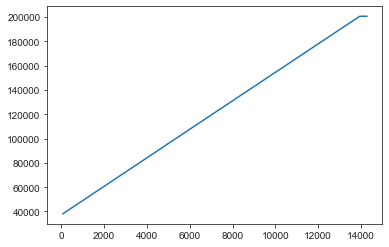

In [6]:
plt.figure()
plt.plot(stim_log.cam_frame)
plt.show()

# Load Camera Log

In [7]:
def addindex2identicalcolumnsname(df):
    cols=pd.Series(df.columns)
    for dup in df.columns.get_duplicates(): 
        cols[df.columns.get_loc(dup)]=[dup+'.'+str(d_idx) for d_idx in range(df.columns.get_loc(dup).sum())]
    df.columns=cols
    return df


In [8]:
filename_mat='G:\MovieIllustration\MovieForIllustration000.mat'
filename_pkl=Path(filename_mat.replace('.mat','.pickle'))

In [9]:
data = h5py.File(filename_mat)
mdata=data['a'].value  # variable in mat file
mdata=mdata.T 

cols_name=['frame_number','x_pos','y_pos','x_body_vect','y_body_vect',
    'body_angle','max_val','fish_blob_val',
    'mid_eye_x','mid_eye_y','hour','minute',
    'stim_number','cum_sum_tail',
    'tail_value','tail_value','tail_value','tail_value','tail_value','tail_value','tail_value','tail_value','tail_value','tail_value',
    'body_angle_origin',
    'tail_angle','tail_angle','tail_angle','tail_angle','tail_angle','tail_angle','tail_angle','tail_angle','tail_angle','tail_angle',
    'first_or_not','timing','lag']

# Convert to Panda Structure:
cam_log = pd.DataFrame(mdata,columns=cols_name)
cam_log=addindex2identicalcolumnsname(cam_log)
#cam_log = cam_log.reindex(sorted(cam_log.columns), axis=1)

#cam_log.to_csv(filename_csv)
cam_log.to_pickle(filename_pkl, compression='infer')

In [10]:
cam_log.head(3)

frame_number     x_pos     y_pos  x_body_vect  y_body_vect  body_angle  \
0       45001.0  198.5862  709.5632     7.095432    -8.405643    0.701075   
1       45002.0  198.5862  709.5632     7.082830    -8.416265    0.699577   
2       45003.0  198.5862  709.5632     7.090290    -8.409981    0.700463   

   max_val  fish_blob_val  mid_eye_x  mid_eye_y  hour  minute  stim_number  \
0    105.0           87.0        0.0        0.0  19.0    16.0          1.0   
1    106.0           87.0        0.0        0.0  19.0    16.0          1.0   
2    106.0           87.0        0.0        0.0  19.0    16.0          1.0   

   cum_sum_tail  tail_value.4  tail_value.5  tail_value.6  tail_value.7  \
0      0.025681      211.3191      134.7680      129.7914      101.2106   
1      0.060722      216.8219      139.1604      133.5361      101.6246   
2      0.001686      211.9180      134.1716      129.5395      100.1606   

   tail_value.8  tail_value.9  tail_value.0  tail_value.1  tail_value.2  \
0      77.09451      47.94807      34.20737      31.60382      17.96649   
1      80.91633      41.89438      40.67622      32.94413      21.53744   
2      76.20502      42.60121      35.46449      33.45832      18.74974   

   tail_value.3  body_angle_origin  tail_angle.5  tail_angle.6  tail_angle.7  \
0     10.234710          -0.869722     -0.003084      0.048655     -0.034625   
1      8.675879          -0.871220      0.007763      0.035710     -0.046938   
2      8.427290          -0.870333      0.000055      0.058446     -0.057914   

   tail_angle.8  tail_angle.9  tail_angle.0  tail_angle.1  tail_angle.2  \
0     -0.008549      0.006333      0.016951     -0.046642      0.047542   
1      0.041789     -0.043522      0.065920     -0.117377      0.124061   
2     -0.008471      0.028293     -0.022095      0.049022     -0.085744   

   tail_angle.3  tail_angle.4  first_or_not   timing   lag  
0      0.045580     -0.165421          -1.0  64292.0  23.0  
1     -0.092832     -0.051402          -1.0  64293.0  22.0  
2      0.165187     -0.139751          -1.0  64293.0  22.0

# Bout Analysis:

In [11]:
from scipy.ndimage.filters import maximum_filter1d 
def max_filter1d_valid(a, W):
    hW = (W-1)//2 # Half window size
    return maximum_filter1d(a,size=W,mode='reflect')#[hW:-hW]

In [12]:
def detect_tail_bouts(tail_angle,NumSegments=9,BCFilt=10,MinFiltSize=20,MaxFiltSize=400,BoutThresh=0.1,MinLength=40,MinAmpl=0.2,TClassif=285):

    # Define Cumul Sum and Find Tracking Nan:
    error_flag=np.where(np.min(tail_angle,1)<-50)[0]
    tail_angle[tail_angle==-100]=0
    cumul_tail_angle=np.cumsum(tail_angle,1)
    num_errors=error_flag.shape[0]

    # For the bout detection we smooth the tail curvature to eliminate kinks due to tracking noise
    notrack=np.where(np.sum(cumul_tail_angle,1)==0)[0]
    smooth_cumul_tail_angle=np.copy(cumul_tail_angle)
    for n in range(1,cumul_tail_angle.shape[1]-1):
        smooth_cumul_tail_angle[:,n]=np.mean(cumul_tail_angle[:,n-1:n+2],1)

    for n in range(cumul_tail_angle.shape[1]):
        tmp=cumul_tail_angle[:,n]
        tmp=signal.savgol_filter(tmp, 11, 2, deriv=0, delta=1.0, axis=-1, mode='interp', cval=0.0)
        smooth_cumul_tail_angle[:,n]=tmp
    
    # Compute difference in segment angles, because we want to detect tail movement
    tmp=np.diff(smooth_cumul_tail_angle,axis=0)
    z=np.zeros((1,tmp.shape[1]))
    fixed_segments_angles=np.vstack((z,tmp))
    fixed_segments_angles[notrack,:]=0
    
    # Interpolate on NoTrack
    if notrack.shape[0]>0:
        if notrack[-1]==tail_angle.shape[0]-1:
            fixed_segments_angles[notrack[:-1]+1,:]=0
        else:
            fixed_segments_angles[notrack+1,:]=0
    real_segment_angles = fixed_segments_angles[:,0:NumSegments];
    
    # Smooth the tail movement
    filtered_segment_angles=np.zeros_like(real_segment_angles)
    for i in range(real_segment_angles.shape[1]):
        filtered_segment_angles[:,i]= signal.convolve(
            real_segment_angles[:,i],
            1/BCFilt*signal.boxcar(M=BCFilt,sym=False),
            mode='same')

    # Sum the angle differences down the length of the tail to give prominence to regions of continuous curvature in one direction
    cumul_filtered_segment_angles=np.cumsum(filtered_segment_angles,1)

    # Sum the absolute value of this accumulated curvature so bends in both directions are considered
    super_cumul_filtered_segment_angles = np.cumsum(np.abs(cumul_filtered_segment_angles),1)
    tail_curv_measure= signal.convolve(
            super_cumul_filtered_segment_angles[:,-1],
            1/BCFilt*signal.boxcar(M=BCFilt,sym=False),
            mode='same')

    # max filter flattens out beat variations (timescale needs to be adjusted according to be well below the interbout length)
    max_filt=max_filter1d_valid(tail_curv_measure,MinFiltSize)
    # min filter removes baseline fluctuations (needs to be well above the bout length)
    min_filt=-max_filter1d_valid(-tail_curv_measure,MaxFiltSize)
    smoother_tail_curve_measure=max_filt-min_filt
    
    # Find when tail is active
    all_bout=smoother_tail_curve_measure>BoutThresh
    all_bout_f=all_bout.astype(float) 

    tmp=np.diff(all_bout_f,axis=0)
    tmp=np.hstack((0,tmp))
    tmp=np.vstack((tmp,np.zeros_like(tmp)))
    all_bout_start=np.max(tmp,0)

    tmp=-1*np.diff(all_bout_f,axis=0)
    tmp=np.hstack((0,tmp))
    tmp=np.vstack((tmp,np.zeros_like(tmp)))
    all_bout_end=np.max(tmp,0)
    
    # Only use bouts with beginning and end within recording and use end as TClassif 285 ms:
    all_bout_start_ind=np.where(all_bout_start)[0]
    all_bout_end_ind=np.where(all_bout_end)[0]
    if all_bout_start_ind[0]>all_bout_end_ind[0]:
        all_bout_end_ind=all_bout_end_ind[1:]

    if len(all_bout_start_ind)>len(all_bout_end_ind):
        all_bout_start_ind=all_bout_start_ind[0:-1]
    
    # Make sure it is compatible with the reshaping done during concatenate_bouts_for_classification
    not_too_late=(all_bout_start_ind+TClassif<tail_angle.shape[0])
    all_bout_start_ind=all_bout_start_ind[not_too_late]
    all_bout_end_ind=all_bout_end_ind[not_too_late]
    not_too_early=(all_bout_start_ind-10>0)
    all_bout_start_ind=all_bout_start_ind[not_too_early]
    all_bout_end_ind=all_bout_end_ind[not_too_early]
        
    bout_duration=np.zeros(all_bout_start_ind.shape)
    bout_ampl=np.zeros(all_bout_start_ind.shape)
    for i in range(len(all_bout_start_ind)):
        bout_duration[i]=all_bout_end_ind[i]-all_bout_start_ind[i]
        tmp=smooth_cumul_tail_angle[all_bout_start_ind[i]:all_bout_end_ind[i],7]-smooth_cumul_tail_angle[all_bout_start_ind[i],7]
        bout_ampl[i]=np.max(np.abs(tmp))
    
    bad_bouts=np.logical_or(bout_duration<MinLength,bout_ampl<MinAmpl)

    good_bout_start_ind=all_bout_start_ind[~bad_bouts]
    good_bout_end_ind=all_bout_end_ind[~bad_bouts]
    bad_bout_start_ind=all_bout_start_ind[bad_bouts]
    bad_bout_end_ind=all_bout_end_ind[bad_bouts]
    
    
    bouts = {'tail_angle':tail_angle,'cumul_tail_angle': cumul_tail_angle,'smoother_tail_curve_measure':smoother_tail_curve_measure, 'smooth_cumul_tail_angle': smooth_cumul_tail_angle,
           'cumul_filtered_segment_angles': cumul_filtered_segment_angles,'super_cumul_filtered_segment_angles': super_cumul_filtered_segment_angles,
           'all_bout': all_bout,'all_bout_start':all_bout_start,'all_bout_end':all_bout_end,
            'all_bout_start_ind': all_bout_start_ind,'all_bout_end_ind': all_bout_end_ind,
           'good_bout_start_ind': good_bout_start_ind,'good_bout_end_ind': good_bout_end_ind,
           'bad_bout_start_ind': bad_bout_start_ind,'bad_bout_end_ind': bad_bout_end_ind
           }
    
    return bouts

In [13]:
def concatenate_bouts_for_classification(x,y,body_angle,tail_angle_mat,id_st,T):
    
    input_bout_flat=np.zeros((len(id_st),T*10))
    for i in range(len(id_st)):
        
        id_st_=id_st[i]-5 # should be 20 but our onset detection work differently
        id_ed_=id_st_+T
        
        #if (id_st_>0)&(id_ed_<len(x)):
        # Extract Bout Information:
        tail_angle_bouts=tail_angle_mat[id_st_:id_ed_,:].T
        x_bouts=x[id_st_:id_ed_]
        y_bouts=y[id_st_:id_ed_]
        angle_bouts=body_angle[id_st_:id_ed_]  
        
        #else:
        #    # Put zeros To avoid shifting the label TO BE IMPROVED
        #     tail_angle_bouts=np.zeros((7,T))
        #    x_bouts=np.zeros((T))
        #    y_bouts=np.zeros((T))
        #    angle_bouts=np.zeros((T))
        # Center the Trajectory:
        x_bouts, y_bouts, angle_bouts = Rotate_Center_Trajectory(x_bouts, y_bouts, angle_bouts)
        angle_bouts=np.unwrap(angle_bouts)
        angle_bouts=angle_bouts-angle_bouts[0]
    
        # Concatenate the tail and trajectory information:
        tmp=tail_angle_bouts.flatten()
        tmp=np.hstack((tmp,x_bouts))
        tmp=np.hstack((tmp,-y_bouts)) # Not sure why
        tmp=np.hstack((tmp,-angle_bouts)) # Not sure why
        input_bout_flat[i,:]=tmp
    
    return input_bout_flat

# Classify Tail Bouts

In [14]:
from keras.callbacks import Callback
from keras.models import Sequential
from keras.layers import Dense , Dropout

from keras.utils import to_categorical ,Sequence
from keras import backend as K
from keras.models import model_from_json

from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())


Using TensorFlow backend.


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13039265601719424481
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4941427507
locality {
  bus_id: 1
  links {
  }
}
incarnation: 9293959434939514440
physical_device_desc: "device: 0, name: GeForce GTX 1060, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [15]:
json_file=open('NeuralNetworkRobust2ShiftNoCS.json', 'r')
model_json = json_file.read()
model = model_from_json(model_json)
model.load_weights("NeuralNetworkRobust2ShiftNoCS.h5")
model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 10, 285)           0         
_________________________________________________________________
permute_1 (Permute)          (None, 285, 10)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 256, 100)          30100     
_________________________________________________________________
batch_normalization_1 (Batch (None, 256, 100)          400       
_________________________________________________________________
activation_1 (Activation)    (None, 256, 100)          0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 128, 100)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 109, 120)        

In [16]:
from scipy.ndimage.filters import maximum_filter1d 
def max_filter1d_valid(a, W):
    hW = (W-1)//2 # Half window size
    return maximum_filter1d(a,size=W,mode='reflect')#[hW:-hW]

In [17]:
df = cam_log.filter(like='tail_angle')
tail_angle=df.as_matrix()
tail_angle[np.isnan(tail_angle)]=-100

# Duration used for Classification
TClassif=285 # in frames
Trec=tail_angle.shape[0]

bouts=detect_tail_bouts(tail_angle)

# Value needed to create NN input:
PixelSize=73
x_tmp=cam_log['x_pos'].values*PixelSize/1000
y_tmp=cam_log['y_pos'].values*PixelSize/1000
body_angle_tmp=cam_log['body_angle'].values

# Rotate Trajectory
x_tmp, y_tmp, body_angle_tmp = Cam2CartBody(x_tmp, y_tmp, body_angle_tmp)

# Extract Tail Angle Uncumulated
tail_angle_mat=bouts['smooth_cumul_tail_angle'][:,:7]
tail_angle_mat=np.hstack((tail_angle_mat[:,0][np.newaxis].T,np.diff(tail_angle_mat,n=1,axis=1)))
id_st=bouts['good_bout_start_ind']
id_ed=bouts['good_bout_end_ind']
input_bout_flat=concatenate_bouts_for_classification(x_tmp,y_tmp,body_angle_tmp,tail_angle_mat,id_st,TClassif)

#proba_idx=model.predict_proba(input_bout_flat)
#proba_idx=np.max(proba_idx,1)
bout_idx=model.predict_classes(input_bout_flat)
# Give meaningfull id to class:
#bout_idx = npi.remap(bout_idx, np.arange(1,27), CatRemapOrder)
#bout_idx_sym=np.array([b if b<13 else 25-b for b in bout_idx.tolist()])
bout_idx=bout_idx-1
bias=(bout_idx>10)*1.0

bout_name=[NameCatShort[b] for b in bout_idx.tolist()]
#bout_name_sym=[NameCatSym[b] for b in bout_idx.tolist()]

# Save Classified bouts in bouts dictionnary:
bouts['input_flat']=input_bout_flat
bouts['cat']=bout_idx
#bouts['cat_sym']=bout_idx_sym
bouts['cat_bias']=bias
bouts['cat_name']=bout_name
#bouts['cat_name_sym']=bout_name_sym

# Create Vector same size as recording containing tail active and categories:
tail_st=np.zeros(Trec)*np.nan
tail_ed=np.zeros(Trec)*np.nan
tail_cat=np.zeros(Trec)-1

for i,val in enumerate(id_st):
    tail_st[val]=i
    tail_cat[id_st[i]:id_ed[i]]=bouts['cat'][i]
    tail_ed[val]=i 

bouts['tail_st']=tail_st
bouts['tail_ed']=tail_ed
bouts['tail_cat']=tail_cat

NumSegments=7
colors = plt.cm.jet(np.linspace(0,1,NumSegments))


In [18]:
fps_original=700

IdSt=1*60*fps_original
Duration=10*fps_original
NumSegments=7

t=np.arange(0,Duration/fps_original,1/fps_original)

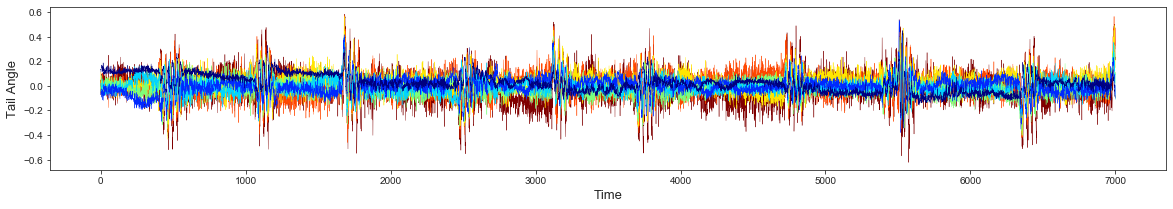

In [19]:
fig = plt.figure(figsize=(20,3))
plt.xlabel('Time', fontsize = 13)
plt.ylabel('Tail Angle', fontsize = 13)
for j in reversed(range(NumSegments)):
    plt.plot(tail_angle[IdSt:IdSt+Duration,j], color=colors[j],lw=.4)
plt.show()

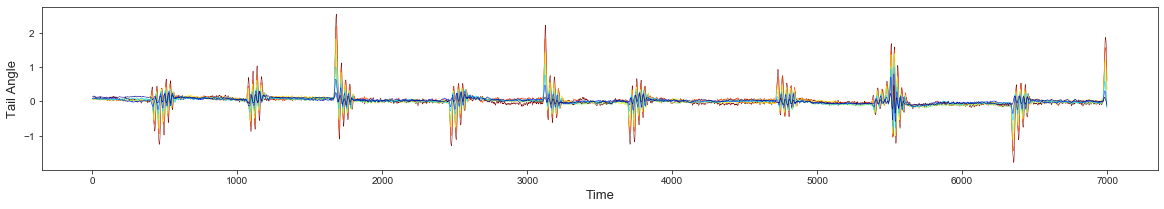

In [20]:
fig = plt.figure(figsize=(20,3))
plt.xlabel('Time', fontsize = 13)
plt.ylabel('Tail Angle', fontsize = 13)
for j in reversed(range(NumSegments)):
    plt.plot(bouts['smooth_cumul_tail_angle'][IdSt:IdSt+Duration,j], color=colors[j],lw=.5)
plt.show()

In [21]:
import matplotlib.gridspec as gridspec
from matplotlib import colors
cmp = JoaoColormap()

In [22]:
id_st_rec=47160
id_ed_rec=88020#186760

In [23]:
j1=np.where(cam_log.frame_number==id_st_rec)[0][0]
print(j1)
j2=np.where(cam_log.frame_number==id_ed_rec)[0][0]
print(j2)

2159
43019


In [24]:
fps_original=700

IdSt=j1#2*60*fps_original
Duration=3*700#j2-j1
print(Duration)
NumSegments=7

t=np.arange(0,Duration/fps_original,1/fps_original)

2100


In [25]:
cam_log.head(2)

frame_number     x_pos     y_pos  x_body_vect  y_body_vect  body_angle  \
0       45001.0  198.5862  709.5632     7.095432    -8.405643    0.701075   
1       45002.0  198.5862  709.5632     7.082830    -8.416265    0.699577   

   max_val  fish_blob_val  mid_eye_x  mid_eye_y  hour  minute  stim_number  \
0    105.0           87.0        0.0        0.0  19.0    16.0          1.0   
1    106.0           87.0        0.0        0.0  19.0    16.0          1.0   

   cum_sum_tail  tail_value.4  tail_value.5  tail_value.6  tail_value.7  \
0      0.025681      211.3191      134.7680      129.7914      101.2106   
1      0.060722      216.8219      139.1604      133.5361      101.6246   

   tail_value.8  tail_value.9  tail_value.0  tail_value.1  tail_value.2  \
0      77.09451      47.94807      34.20737      31.60382      17.96649   
1      80.91633      41.89438      40.67622      32.94413      21.53744   

   tail_value.3  body_angle_origin  tail_angle.5  tail_angle.6  tail_angle.7  \
0     10.234710          -0.869722     -0.003084      0.048655     -0.034625   
1      8.675879          -0.871220      0.007763      0.035710     -0.046938   

   tail_angle.8  tail_angle.9  tail_angle.0  tail_angle.1  tail_angle.2  \
0     -0.008549      0.006333      0.016951     -0.046642      0.047542   
1      0.041789     -0.043522      0.065920     -0.117377      0.124061   

   tail_angle.3  tail_angle.4  first_or_not   timing   lag  
0      0.045580     -0.165421          -1.0  64292.0  23.0  
1     -0.092832     -0.051402          -1.0  64293.0  22.0

In [26]:
bouts['cumul_tail_angle'].shape

(155711, 10)

(-0.058878365937485085,
 1.0505872714720843,
 -0.1173308161571496,
 0.11733081615714983)

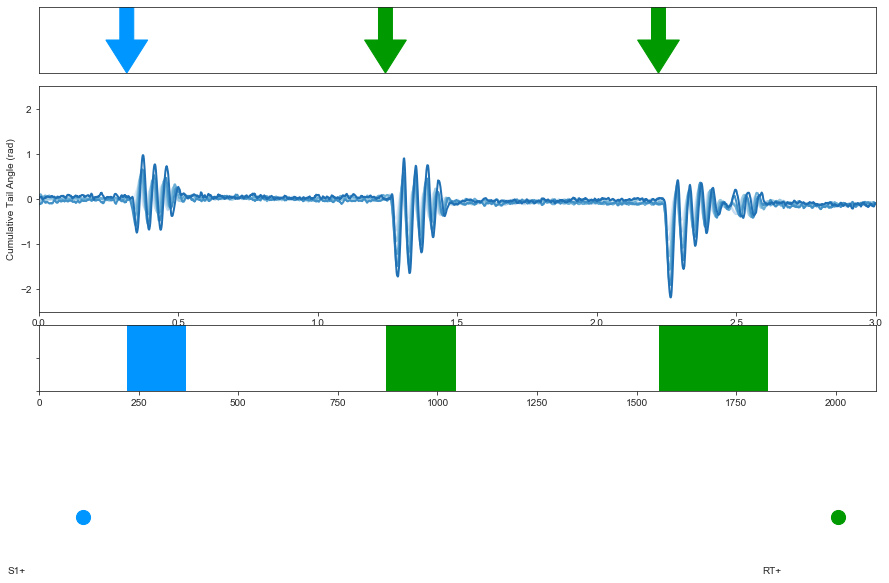

In [27]:

# Extract bout in the segment considered:
tail_cat_tmp = bouts['tail_cat'][IdSt:IdSt+Duration].astype('int')

tail_cat_sym_tmp = np.copy(tail_cat_tmp)#bouts['tail_cat_sym'][IdSt:IdSt+Duration].astype('int')
tail_cat_sym_tmp[tail_cat_sym_tmp>-1] = tail_cat_sym_tmp[tail_cat_sym_tmp>-1]%11
tail_st_tmp = bouts['tail_st'][IdSt:IdSt+Duration].astype('int')
id_st_bout = np.argwhere(tail_st_tmp>0).flatten()

cat_tmp = tail_cat_tmp[id_st_bout+1]
cat_sym_tmp=np.array([b%11 for b in cat_tmp.tolist()])#np.array([b if b<13 else 25-b for b in cat_tmp.tolist()])


plt.figure(figsize=(15,10))

G = gridspec.GridSpec(7,1) 

axis = plt.subplot(G[0])
for i in range(len(id_st_bout)):
    if cat_tmp[i]>10:
        plt.arrow(t[id_st_bout[i]],0, 0, 1,length_includes_head=True,width=0.05,color=cmp(cat_sym_tmp[i]),head_length=0.5)
    else:
        plt.arrow(t[id_st_bout[i]],1, 0, -1,length_includes_head=True,width=0.05,color=cmp(cat_sym_tmp[i]),head_length=0.5)

axis.set_xticks([])
axis.set_yticks([])
axis.set_xlim(0,Duration/fps_original)

axis = plt.subplot(G[1:4])

Ncolors = 8
#colormap = plt.cm.Dark2# ListedColormap
colormap = plt.cm.Blues# LinearSegmentedColormap
Ncolors = min(colormap.N,Ncolors)
mapcolors = [colormap(int(x*colormap.N/Ncolors)) for x in range(Ncolors)]
l_styles = ['-']
m_styles = ['']
for ii,ip in enumerate(range(1,8)):
    axis.plot(t,bouts['smooth_cumul_tail_angle'][IdSt:IdSt+Duration,ip],color=mapcolors[ii],lw=2)
axis.set_ylabel('Cumulative Tail Angle (rad)')
axis.set_ylim(-2.5,2.5)
axis.set_xlim(0,Duration/fps_original)

axis = plt.subplot(G[4])
tmp=tail_cat_sym_tmp
cmpW = JoaoColormap()
cmpW.set_under(color='white')
axis.imshow(tmp[:,np.newaxis].T,aspect='auto', cmap=cmpW,vmin=0,vmax=10)#,extent=[0,10,13,0])
axis.set_yticklabels([])

axis = plt.subplot(G[6])

cat_sym_unique=np.unique(cat_sym_tmp)
for i in range(len(cat_sym_unique)):
    tmp_str=NameCatShort[cat_sym_unique[i]]
    axis.scatter(i,0,color=cmp(cat_sym_unique[i]),s=200)
    axis.text(i-0.1,-0.2,tmp_str)
axis.axis('off')


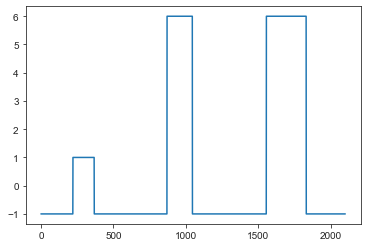

In [28]:
plt.plot(tmp)

(-0.5130911181616723,
 10.589055068180013,
 -0.1173308161571496,
 0.11733081615714983)

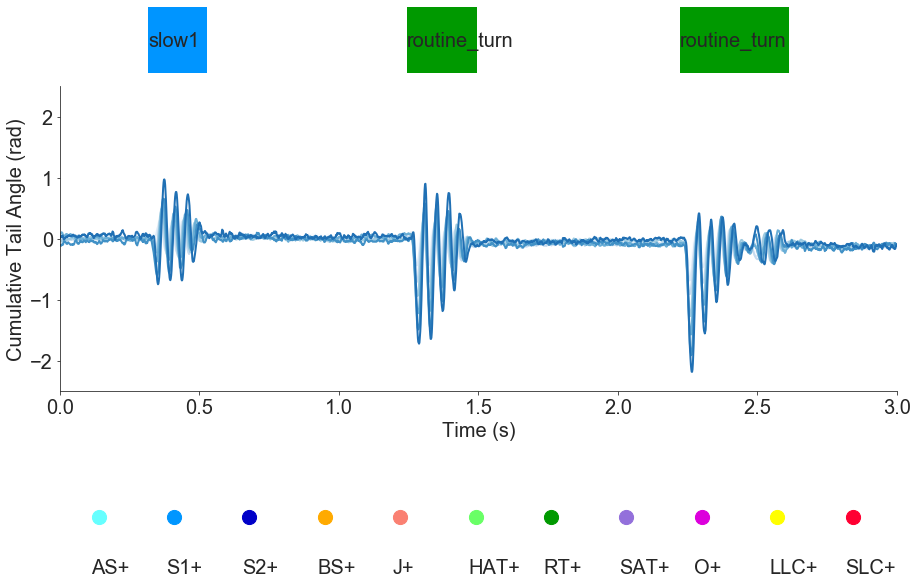

In [29]:

# Extract bout in the segment considered:
tail_cat_tmp = bouts['tail_cat'][IdSt:IdSt+Duration].astype('int')

tail_cat_sym_tmp = np.copy(tail_cat_tmp)#bouts['tail_cat_sym'][IdSt:IdSt+Duration].astype('int')
tail_cat_sym_tmp[tail_cat_sym_tmp>-1] = tail_cat_sym_tmp[tail_cat_sym_tmp>-1]%11
tail_st_tmp = bouts['tail_st'][IdSt:IdSt+Duration].astype('int')
id_st_bout = np.argwhere(tail_st_tmp>0).flatten()

cat_tmp = tail_cat_tmp[id_st_bout+1]
cat_sym_tmp=np.array([b%11 for b in cat_tmp.tolist()])#np.array([b if b<13 else 25-b for b in cat_tmp.tolist()])


plt.figure(figsize=(15,10))

SMALL_SIZE = 20
MEDIUM_SIZE = 20
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


G = gridspec.GridSpec(7,1) 

   # axis.text(i-0.1,-0.2,tmp_str)

axis = plt.subplot(G[0])
tmp=tail_cat_sym_tmp
cmpW = JoaoColormap()
cmpW.set_under(color='white')
axis.imshow(tmp[:,np.newaxis].T,extent=[0,t[-1],-1,1],aspect='auto', cmap=cmpW,vmin=0,vmax=10)#,extent=[0,10,13,0])
axis.set_yticklabels([])
axis.set_xticklabels([])
axis.axis('off')

for i in range(len(id_st_bout)):
    if cat_tmp[i]>10:
        pass#plt.arrow(t[id_st_bout[i]],0, 0, 1,length_includes_head=True,width=0.05,color=cmp(cat_sym_tmp[i]),head_length=0.5)
    else:
        pass#plt.arrow(t[id_st_bout[i]],1, 0, -1,length_includes_head=True,width=0.05,color=cmp(cat_sym_tmp[i]),head_length=0.5)
    tmp_str=NameCat[cat_sym_tmp[i]][2:]
    axis.text(t[id_st_bout[i]],-0.2,tmp_str)

axis = plt.subplot(G[1:5])

Ncolors = 8
#colormap = plt.cm.Dark2# ListedColormap
colormap = plt.cm.Blues# LinearSegmentedColormap
Ncolors = min(colormap.N,Ncolors)
mapcolors = [colormap(int(x*colormap.N/Ncolors)) for x in range(Ncolors)]
l_styles = ['-']
m_styles = ['']
for ii,ip in enumerate(range(1,8)):
    axis.plot(t,bouts['smooth_cumul_tail_angle'][IdSt:IdSt+Duration,ip],color=mapcolors[ii],lw=2)
axis.set_ylabel('Cumulative Tail Angle (rad)')
axis.set_xlabel('Time (s)')

axis.set_ylim(-2.5,2.5)
axis.set_xlim(0,Duration/fps_original)
axis.spines['right'].set_visible(False)
axis.spines['top'].set_visible(False)
axis = plt.subplot(G[6])

cat_sym_unique=np.arange(11)#np.unique(cat_sym_tmp)
for i in range(len(cat_sym_unique)):
    tmp_str=NameCatShort[cat_sym_unique[i]]
    axis.scatter(i,0,color=cmp(cat_sym_unique[i]),s=200)
    axis.text(i-0.1,-0.2,tmp_str)
axis.axis('off')


In [30]:
path = 'G:\MovieIllustration\images'
files = []
# r=root, d=directories, f = files
for r, d, f in os.walk(path):
    for file in f:
        if '.png' in file:
            files.append(os.path.join(r, file))

In [31]:
j1=np.where(cam_log.frame_number==id_st_rec)[0][0]
print(j1)
j2=np.where(cam_log.frame_number==id_ed_rec)[0][0]
print(j2)

2159
43019


In [32]:
len(files)

7008

In [33]:
from PIL import Image

def load_image( infilename ) :
    img = Image.open( infilename )
    img.load()
    data = np.asarray( img, dtype="int32" )
    return data

def save_image( npdata, outfilename ) :
    img = Image.fromarray( np.asarray( np.clip(npdata,0,255), dtype="uint8"), "L" )
    img.save( outfilename )

In [34]:
iframe=6000

In [35]:
img=load_image(files[iframe])

In [36]:
files[iframe]

'G:\\MovieIllustration\\images\\0000167160_000573.png'

In [37]:
num=int(files[iframe][28:28+10])
j2=np.where(cam_log.frame_number==num)[0][0]

In [38]:
j2

122159

In [39]:
img.shape

(948, 948)

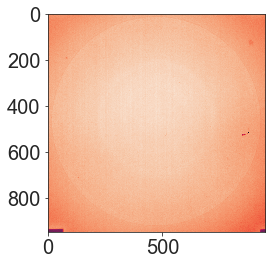

In [40]:
plt.imshow(img)

In [41]:
cam_log[cam_log['frame_number']==j2]

frame_number     x_pos     y_pos  x_body_vect  y_body_vect  body_angle  \
77158      122159.0  800.7473  654.4506    -4.018296     10.23979    3.515547   

       max_val  fish_blob_val  mid_eye_x  mid_eye_y  hour  minute  \
77158     99.0           91.0        0.0        0.0  19.0    18.0   

       stim_number  cum_sum_tail  tail_value.4  tail_value.5  tail_value.6  \
77158          7.0      0.008627      161.5918      106.3098      88.66066   

       tail_value.7  tail_value.8  tail_value.9  tail_value.0  tail_value.1  \
77158      73.69077      61.01337      38.53167      33.53916      31.29889   

       tail_value.2  tail_value.3  body_angle_origin  tail_angle.5  \
77158      14.42061      5.075867           1.944751     -0.008363   

       tail_angle.6  tail_angle.7  tail_angle.8  tail_angle.9  tail_angle.0  \
77158      0.012263     -0.100547       0.13017      -0.14243      0.117535   

       tail_angle.1  tail_angle.2  tail_angle.3  tail_angle.4  first_or_not  \
77158     -0.122817      0.083144       0.00915     -0.015172          -1.0   

         timing  lag  
77158  174455.0  0.0

In [42]:
id_tmp=np.where(cam_log['frame_number']==j2)[0][0]

In [43]:
j2

122159

In [44]:
id_tmp

77158

In [45]:
cam_log.x_pos[j2]

524.2581

In [46]:
cam_log.y_pos[j2]

851.5054

In [47]:
cam_log.iloc[j2]

frame_number    167160.000000
x_pos              524.258100
y_pos              851.505400
x_body_vect         -3.022313
y_body_vect         10.576650
                    ...      
tail_angle.3        -0.299335
tail_angle.4        -0.596713
first_or_not        -1.000000
timing          238726.000000
lag                  0.000000
Name: 122159, Length: 38, dtype: float64

In [48]:
cam_log.head(2)

frame_number     x_pos     y_pos  x_body_vect  y_body_vect  body_angle  \
0       45001.0  198.5862  709.5632     7.095432    -8.405643    0.701075   
1       45002.0  198.5862  709.5632     7.082830    -8.416265    0.699577   

   max_val  fish_blob_val  mid_eye_x  mid_eye_y  hour  minute  stim_number  \
0    105.0           87.0        0.0        0.0  19.0    16.0          1.0   
1    106.0           87.0        0.0        0.0  19.0    16.0          1.0   

   cum_sum_tail  tail_value.4  tail_value.5  tail_value.6  tail_value.7  \
0      0.025681      211.3191      134.7680      129.7914      101.2106   
1      0.060722      216.8219      139.1604      133.5361      101.6246   

   tail_value.8  tail_value.9  tail_value.0  tail_value.1  tail_value.2  \
0      77.09451      47.94807      34.20737      31.60382      17.96649   
1      80.91633      41.89438      40.67622      32.94413      21.53744   

   tail_value.3  body_angle_origin  tail_angle.5  tail_angle.6  tail_angle.7  \
0     10.234710          -0.869722     -0.003084      0.048655     -0.034625   
1      8.675879          -0.871220      0.007763      0.035710     -0.046938   

   tail_angle.8  tail_angle.9  tail_angle.0  tail_angle.1  tail_angle.2  \
0     -0.008549      0.006333      0.016951     -0.046642      0.047542   
1      0.041789     -0.043522      0.065920     -0.117377      0.124061   

   tail_angle.3  tail_angle.4  first_or_not   timing   lag  
0      0.045580     -0.165421          -1.0  64292.0  23.0  
1     -0.092832     -0.051402          -1.0  64293.0  22.0

# What Frame To Save

In [49]:
%run StimuliPlayerSession.py

In [50]:
sps=StimuliPlayerSession()
sps.load('G:\MovieIllustration\stimlog_2019_10_03_19_16_08.txt')

Success.


In [51]:
iframe_st=2100#870+76
iframe_ed=3100


In [52]:
import matplotlib.patches as patches
from skimage.transform import rescale, resize, downscale_local_mean
import matplotlib
import matplotlib.gridspec as gridspec
from matplotlib import colors
cmp = JoaoColormap()

In [53]:
img_fish=load_image(files[iframe])


In [54]:
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.lines import Line2D

In [75]:
for iframe in range(iframe_st,iframe_ed):
    print(iframe)
    #print(files[iframe])
    # Get Number:
    #print(int(files[iframe][28:28+10]))
    num=int(files[iframe][28:28+10])
    j2=np.where(cam_log.frame_number==num)[0][0]
    #print(j2)
    j1=j2-700*5
    #print(j1)
    fps_original=700
    
    if j1>0:
        IdSt=j1#2*60*fps_original
        Duration=j2-j1#3*700#j2-j1
        NumSegments=7

        t=np.arange(0,Duration/fps_original,1/fps_original)
        
        # Load Stimuli Shader
        j_stim_log=np.where(stim_log.cam_frame==num)[0]
        if len(j_stim_log)>0:
            j_stim_log=j_stim_log[0]
            Tensor=sps.render(TimeSpan('frame',j_stim_log),TimeSpan('frame',j_stim_log+1))
            r, g, b = Tensor[0][:,:,0], Tensor[0][:,:,1], Tensor[0][:,:,2]
            Tensor = 0.2989 * r + 0.5870 * g + 0.1140 * b

            # Extract bout in the segment considered:
            tail_cat_tmp = bouts['tail_cat'][IdSt+Duration-1750:IdSt+Duration+1750].astype('int')

            tail_cat_sym_tmp = np.copy(tail_cat_tmp)#bouts['tail_cat_sym'][IdSt:IdSt+Duration].astype('int')
            tail_cat_sym_tmp[tail_cat_sym_tmp>-1] = tail_cat_sym_tmp[tail_cat_sym_tmp>-1]%11
            tail_st_tmp = bouts['tail_st'][IdSt+Duration-1750:IdSt+Duration+1750].astype('int')
            id_st_bout = np.argwhere(tail_st_tmp>0).flatten()

            id_st_bout=id_st_bout[id_st_bout+1<len(tail_cat_tmp)]
            cat_tmp = tail_cat_tmp[id_st_bout+1]
            cat_sym_tmp=np.array([b%11 for b in cat_tmp.tolist()])#np.array([b if b<13 else 25-b for b in cat_tmp.tolist()])


            plt.figure(figsize=(27,9))

            SMALL_SIZE = 15
            MEDIUM_SIZE = 20
            BIGGER_SIZE = 25

            plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
            plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
            plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
            plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
            plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
            plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
            plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


            G = gridspec.GridSpec(6,12) 
    
            img_fish=load_image(files[iframe])
            
            
            axis = plt.subplot(G[:,0:5])

            x=cam_log.y_pos[j2-700*3:j2]
            y=947-cam_log.x_pos[j2-700*3:j2]
            cmap = matplotlib.cm.get_cmap('Reds')
            normalize = matplotlib.colors.Normalize(vmin=0, vmax=2*len(x))
            z=np.arange(len(x))
            colors_scatter = [cmap(normalize(value)) for value in z]

            axis.scatter(x, y, color=colors_scatter,s=0.1)

            img_stim = 0.2* resize(Tensor, (948,948),anti_aliasing=True)/255.

            img_fish=img_fish/255

            img_w_stim=img_fish+img_stim
            axis.imshow(img_w_stim,extent=[0,948,0,948],cmap='gray')
            axis.axis('off')
            # Create a Rectangle patch
            rect = patches.Rectangle((cam_log.y_pos[j2]-60,947-cam_log.x_pos[j2]-60),120,120,linewidth=1,edgecolor='r',facecolor='none')

            # Add the patch to the Axes
            axis.add_patch(rect)
            
            axis = plt.subplot(G[0:3,5:])
            axis.imshow(img_fish,extent=[0,948,0,948],cmap='gray')
            #axis.plot(cam_log.y_pos[j2-700:j2],947-cam_log.x_pos[j2-700:j2])
            axis.set_xlim(cam_log.y_pos[j2]-60-2,cam_log.y_pos[j2]+60+2)
            axis.set_ylim(947-cam_log.x_pos[j2]-60-2,947-cam_log.x_pos[j2]+60+2)
            
            # Create a Rectangle patch
            rect = patches.Rectangle((cam_log.y_pos[j2]-60,947-cam_log.x_pos[j2]-60),120,120,linewidth=3,edgecolor='r',facecolor='none')
            # Add the patch to the Axes
            axis.add_patch(rect)
            
            axis.axis('off')

            
            axis = plt.subplot(G[4:,5:])
            axis.arrow(2.5,-4, 0, 2, head_width=0.1, head_length=0.5, fc='r', ec='r')

            Ncolors = 8
            #colormap = plt.cm.Dark2# ListedColormap
            colormap = plt.cm.Blues# LinearSegmentedColormap
            Ncolors = min(colormap.N,Ncolors)
            mapcolors = [colormap(int(x*colormap.N/Ncolors)) for x in range(Ncolors)]
            l_styles = ['-']
            m_styles = ['']
            for ii,ip in enumerate(range(1,8)):
                axis.plot(t,bouts['smooth_cumul_tail_angle'][IdSt+Duration-1750:IdSt+Duration+1750,ip],color=mapcolors[ii],lw=2)
            
            #axis.set_ylabel('Tail Angle (rad)',rotation='horizontal')
            #axis.set_xlabel('Time (s)')
            

            axis.set_ylim(-3,3)
            axis.set_xlim(0,Duration/fps_original)

            #axis = plt.subplot(G[15,:])
            tmp=tail_cat_sym_tmp
            cmpW = JoaoColormap()
            cmpW.set_under(color='white')
            
            axis.imshow(tmp[:,np.newaxis].T,extent=[0,t[-1],-3,-2],aspect='auto', cmap=cmpW,vmin=0,vmax=10)#,extent=[0,10,13,0])
            

            for i in range(len(id_st_bout)):
                if cat_tmp[i]>10:
                    pass#plt.arrow(t[id_st_bout[i]],0, 0, 1,length_includes_head=True,width=0.05,color=cmp(cat_sym_tmp[i]),head_length=0.5)
                else:
                    pass#plt.arrow(t[id_st_bout[i]],1, 0, -1,length_includes_head=True,width=0.05,color=cmp(cat_sym_tmp[i]),head_length=0.5)
                tmp_str=NameCat[cat_sym_tmp[i]][2:]
                axis.text(t[id_st_bout[i]],-3.5,tmp_str)
                
            line = Line2D([0,0.3],[3.14/2,3.14/2],color='k',lw=2)
            axis.add_artist(line)
            axis.text(0.05,3.14/2+0.1,'300 ms')
            
            line = Line2D([0.01,0.01],[-3.14/2,3.14/2],color='k',lw=2)
            axis.add_artist(line)
            
            
            #axis.text(-0.37,0.23,'Tail Angle')

            axis.text(-0.2,0,'180°')

            

            #axis.text(t[id_st_bout[i]],-1.6,tmp_str)
            #title=str(np.round((iframe-iframe_st)/32,2))+ ' s'
            
            axis.spines['left'].set_visible(False)
            axis.spines['right'].set_visible(False)
            axis.spines['top'].set_visible(False)
            axis.spines['bottom'].set_visible(False)
            
            axis.set_yticklabels([])
            axis.set_xticklabels([])
            axis.get_yaxis().set_visible(False)
            axis.get_xaxis().set_visible(False)
            
            axis.set_title('Tail Angle')
            #plt.suptitle(title)
            plt.draw()
            filename_fig='G:\MovieIllustration\AnnotatedMovie'+'\img_'+str(iframe)+'.png'
            plt.savefig(filename_fig,dpi=100)
            plt.close("all")
            
            
            
            

2100
2101
2102
2103
2104
2105
2106
2107
2108
2109
2110
2111
2112
2113
2114
2115
2116
2117
2118
2119
2120
2121
2122
2123
2124
2125
2126
2127
2128
2129
2130
2131
2132
2133
2134
2135
2136
2137
2138
2139
2140
2141
2142
2143
2144
2145
2146
2147
2148
2149
2150
2151
2152
2153
2154
2155
2156
2157
2158
2159
2160
2161
2162
2163
2164
2165
2166
2167
2168
2169
2170
2171
2172
2173
2174
2175
2176
2177
2178
2179
2180
2181
2182
2183
2184
2185
2186
2187
2188
2189
2190
2191
2192
2193
2194
2195
2196
2197
2198
2199
2200
2201
2202
2203
2204
2205
2206
2207
2208
2209
2210
2211
2212
2213
2214
2215
2216
2217
2218
2219
2220
2221
2222
2223
2224
2225
2226
2227
2228
2229
2230
2231
2232
2233
2234
2235
2236
2237
2238
2239
2240
2241
2242
2243
2244
2245
2246
2247
2248
2249
2250
2251
2252
2253
2254
2255
2256
2257
2258
2259
2260
2261
2262
2263
2264
2265
2266
2267
2268
2269
2270
2271
2272
2273
2274
2275
2276
2277
2278
2279
2280
2281
2282
2283
2284
2285
2286
2287
2288
2289
2290
2291
2292
2293
2294
2295
2296
2297
2298
2299


In [56]:
for iframe in range(iframe_st,iframe_ed):
    print(iframe)
    #print(files[iframe])
    # Get Number:
    #print(int(files[iframe][28:28+10]))
    num=int(files[iframe][28:28+10])
    j2=np.where(cam_log.frame_number==num)[0][0]
    #print(j2)
    j1=j2-700*5
    #print(j1)
    fps_original=700
    
    if j1>0:
        IdSt=j1#2*60*fps_original
        Duration=j2-j1#3*700#j2-j1
        NumSegments=7

        t=np.arange(0,Duration/fps_original,1/fps_original)
        
        # Load Stimuli Shader
        j_stim_log=np.where(stim_log.cam_frame==num)[0]
        if len(j_stim_log)>0:
            j_stim_log=j_stim_log[0]
            Tensor=sps.render(TimeSpan('frame',j_stim_log),TimeSpan('frame',j_stim_log+1))
            r, g, b = Tensor[0][:,:,0], Tensor[0][:,:,1], Tensor[0][:,:,2]
            Tensor = 0.2989 * r + 0.5870 * g + 0.1140 * b

            # Extract bout in the segment considered:
            tail_cat_tmp = bouts['tail_cat'][IdSt-Duration:IdSt].astype('int')

            tail_cat_sym_tmp = np.copy(tail_cat_tmp)#bouts['tail_cat_sym'][IdSt:IdSt+Duration].astype('int')
            tail_cat_sym_tmp[tail_cat_sym_tmp>-1] = tail_cat_sym_tmp[tail_cat_sym_tmp>-1]%11
            tail_st_tmp = bouts['tail_st'][IdSt-Duration:IdSt].astype('int')
            id_st_bout = np.argwhere(tail_st_tmp>0).flatten()

            id_st_bout=id_st_bout[id_st_bout+1<len(tail_cat_tmp)]
            cat_tmp = tail_cat_tmp[id_st_bout+1]
            cat_sym_tmp=np.array([b%11 for b in cat_tmp.tolist()])#np.array([b if b<13 else 25-b for b in cat_tmp.tolist()])


            plt.figure(figsize=(27,9))

            SMALL_SIZE = 15
            MEDIUM_SIZE = 20
            BIGGER_SIZE = 25

            plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
            plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
            plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
            plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
            plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
            plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
            plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


            G = gridspec.GridSpec(6,12) 
    
            img_fish=load_image(files[iframe])
            
            
            axis = plt.subplot(G[:,0:5])

            x=cam_log.y_pos[j2-700*3:j2]
            y=947-cam_log.x_pos[j2-700*3:j2]
            cmap = matplotlib.cm.get_cmap('Reds')
            normalize = matplotlib.colors.Normalize(vmin=0, vmax=2*len(x))
            z=np.arange(len(x))
            colors_scatter = [cmap(normalize(value)) for value in z]

            axis.scatter(x, y, color=colors_scatter,s=0.1)

            img_stim = 0.2* resize(Tensor, (948,948),anti_aliasing=True)/255.

            img_fish=img_fish/255

            img_w_stim=img_fish+img_stim
            axis.imshow(img_w_stim,extent=[0,948,0,948],cmap='gray')
            axis.axis('off')
            # Create a Rectangle patch
            rect = patches.Rectangle((cam_log.y_pos[j2]-60,947-cam_log.x_pos[j2]-60),120,120,linewidth=1,edgecolor='r',facecolor='none')

            # Add the patch to the Axes
            axis.add_patch(rect)

            
            axis = plt.subplot(G[0:3,5:])
            axis.imshow(img_fish,extent=[0,948,0,948],cmap='gray')
            #axis.plot(cam_log.y_pos[j2-700:j2],947-cam_log.x_pos[j2-700:j2])
            axis.set_xlim(cam_log.y_pos[j2]-60-2,cam_log.y_pos[j2]+60+2)
            axis.set_ylim(947-cam_log.x_pos[j2]-60-2,947-cam_log.x_pos[j2]+60+2)
            
            # Create a Rectangle patch
            rect = patches.Rectangle((cam_log.y_pos[j2]-60,947-cam_log.x_pos[j2]-60),120,120,linewidth=3,edgecolor='r',facecolor='none')
            # Add the patch to the Axes
            axis.add_patch(rect)
            
            axis.axis('off')

            
            
            #plt.suptitle(title)
            plt.draw()
            filename_fig='G:\MovieIllustration\AnnotatedMovieWStim'+'\img_'+str(iframe)+'.png'
            plt.savefig(filename_fig,dpi=100)
            plt.close("all")
            
            
            
            

2100
2101
2102
2103
2104
2105
2106
2107
2108
2109
2110
2111
2112
2113
2114
2115
2116
2117
2118
2119
2120
2121
2122
2123
2124
2125
2126
2127
2128
2129
2130
2131
2132
2133
2134
2135
2136
2137
2138
2139
2140
2141
2142
2143
2144
2145
2146
2147
2148
2149
2150
2151
2152
2153
2154
2155
2156
2157
2158
2159
2160
2161
2162
2163
2164
2165
2166
2167
2168
2169
2170
2171
2172
2173
2174
2175
2176
2177
2178
2179
2180
2181
2182
2183
2184
2185
2186
2187
2188
2189
2190
2191
2192
2193
2194
2195
2196
2197
2198
2199
2200
2201
2202
2203
2204
2205
2206
2207
2208
2209
2210
2211
2212
2213
2214
2215
2216
2217
2218
2219
2220
2221
2222
2223
2224
2225
2226
2227
2228
2229
2230
2231
2232
2233
2234
2235
2236
2237
2238
2239
2240
2241
2242
2243
2244
2245
2246
2247
2248
2249
2250
2251
2252
2253
2254
2255
2256
2257
2258
2259
2260
2261
2262
2263
2264
2265
2266
2267
2268
2269
2270
2271
2272
2273
2274
2275
2276
2277
2278
2279
2280
2281
2282
2283
2284
2285
2286
2287
2288
2289
2290
2291
2292
2293
2294
2295
2296
2297
2298
2299


In [58]:
Duration/2

1750.0

In [ ]:
len(files)

In [ ]:
for iframe in range(5640,len(files)):
    print(iframe)
    #print(files[iframe])
    # Get Number:
    #print(int(files[iframe][28:28+10]))
    num=int(files[iframe][28:28+10])
    j2=np.where(cam_log.frame_number==num)[0][0]
    #print(j2)
    j1=j2-700*5
    #print(j1)
    fps_original=700
    if j1>0:
        IdSt=j1#2*60*fps_original
        Duration=j2-j1#3*700#j2-j1
        NumSegments=7

        t=np.arange(0,Duration/fps_original,1/fps_original)



        # Extract bout in the segment considered:
        tail_cat_tmp = bouts['tail_cat'][IdSt:IdSt+Duration].astype('int')

        tail_cat_sym_tmp = np.copy(tail_cat_tmp)#bouts['tail_cat_sym'][IdSt:IdSt+Duration].astype('int')
        tail_cat_sym_tmp[tail_cat_sym_tmp>-1] = tail_cat_sym_tmp[tail_cat_sym_tmp>-1]%11
        tail_st_tmp = bouts['tail_st'][IdSt:IdSt+Duration].astype('int')
        id_st_bout = np.argwhere(tail_st_tmp>0).flatten()
        
        id_st_bout=id_st_bout[id_st_bout+1<len(id_st_bout)]
        cat_tmp = tail_cat_tmp[id_st_bout+1]
        cat_sym_tmp=np.array([b%11 for b in cat_tmp.tolist()])#np.array([b if b<13 else 25-b for b in cat_tmp.tolist()])


        plt.figure(figsize=(25,25))

        SMALL_SIZE = 20
        MEDIUM_SIZE = 20
        BIGGER_SIZE = 25

        plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
        plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
        plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
        plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
        plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
        plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
        plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


        G = gridspec.GridSpec(16,2) 
            
        img=load_image(files[iframe])
        axis = plt.subplot(G[0:10,0])
        axis.imshow(img,extent=[0,948,0,948],cmap='gray')
        axis.axis('off')
        
        # Create a Rectangle patch
        rect = patches.Rectangle((cam_log.y_pos[j2]-100,947-cam_log.x_pos[j2]-100),200,200,linewidth=1,edgecolor='r',facecolor='none')

        # Add the patch to the Axes
        axis.add_patch(rect)
            
        axis = plt.subplot(G[0:10,1])
        axis.imshow(img,extent=[1000,1000+948,0,0+948],cmap='gray')
        #axis.plot(cam_log.y_pos[j2-700:j2],947-cam_log.x_pos[j2-700:j2])

        axis.set_xlim(1000+cam_log.y_pos[j2]-100,1000+cam_log.y_pos[j2]+100)
        axis.set_ylim(947-cam_log.x_pos[j2]-100,947-cam_log.x_pos[j2]+100)
        axis.axis('off')

        
        axis = plt.subplot(G[10:14,:])
        Ncolors = 8
        #colormap = plt.cm.Dark2# ListedColormap
        colormap = plt.cm.Blues# LinearSegmentedColormap
        Ncolors = min(colormap.N,Ncolors)
        mapcolors = [colormap(int(x*colormap.N/Ncolors)) for x in range(Ncolors)]
        l_styles = ['-']
        m_styles = ['']
        for ii,ip in enumerate(range(1,8)):
            axis.plot(t,bouts['smooth_cumul_tail_angle'][IdSt:IdSt+Duration,ip],color=mapcolors[ii],lw=2)
        axis.set_ylabel('Tail Angle (rad)')
        axis.set_xlabel('Time (s)')

        axis.set_ylim(-2.5,2.5)
        axis.set_xlim(0,Duration/fps_original)
        axis.spines['right'].set_visible(False)
        axis.spines['top'].set_visible(False)
        
        axis = plt.subplot(G[15,:])
        tmp=tail_cat_sym_tmp
        cmpW = JoaoColormap()
        cmpW.set_under(color='white')
        axis.imshow(tmp[:,np.newaxis].T,extent=[0,t[-1],-1,1],aspect='auto', cmap=cmpW,vmin=0,vmax=10)#,extent=[0,10,13,0])
        axis.set_yticklabels([])
        axis.set_xticklabels([])
        axis.axis('off')

        for i in range(len(id_st_bout)):
            if cat_tmp[i]>10:
                pass#plt.arrow(t[id_st_bout[i]],0, 0, 1,length_includes_head=True,width=0.05,color=cmp(cat_sym_tmp[i]),head_length=0.5)
            else:
                pass#plt.arrow(t[id_st_bout[i]],1, 0, -1,length_includes_head=True,width=0.05,color=cmp(cat_sym_tmp[i]),head_length=0.5)
            tmp_str=NameCat[cat_sym_tmp[i]][2:]
            axis.text(t[id_st_bout[i]],-1.6,tmp_str)

        
        #axis = plt.subplot(G[7])
        #cat_sym_unique=np.arange(11)#np.unique(cat_sym_tmp)
        #for i in range(len(cat_sym_unique)):
        #    tmp_str=NameCatShort[cat_sym_unique[i]]
        #    axis.scatter(i,0,color=cmp(cat_sym_unique[i]),s=200)
        #    axis.text(i-0.1,-0.2,tmp_str)
        #axis.axis('off')


        #plt.suptitle(title)
        plt.draw()
        filename_fig='G:\MovieIllustration\AnnotatedMovie'+'\img_'+str(iframe)+'.png'
        plt.savefig(filename_fig)
        plt.close("all")

In [ ]:
np.round(cam_log.x_pos[j2]-100)

In [ ]:
tail_cat_tmp

In [ ]:
id_st_bout

In [ ]:
Duration/fps_original

In [ ]:
t.shape

In [ ]:
IdSt

In [ ]:
Duration

In [ ]:
bouts['smooth_cumul_tail_angle'][IdSt:IdSt+Duration,ip].shape

In [ ]:
import matplotlib.animation as animation
import numpy as np
from pylab import *


dpi = 100

def ani_frame():
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_aspect('equal')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    im = ax.imshow(rand(300,300),cmap='gray',interpolation='nearest')
    im.set_clim([0,1])
    fig.set_size_inches([5,5])


    tight_layout()


    def update_img(n):
        tmp = rand(300,300)
        im.set_data(tmp)
        return im

    #legend(loc=0)
    ani = animation.FuncAnimation(fig,update_img,300,interval=30)
    writer = animation.writers['ffmpeg'](fps=30)

    ani.save('G:\demo.mp4',writer=writer,dpi=dpi)
    return ani

In [ ]:
ani_frame()